# Images with Significant Background

**Scott Prahl**

**Sept 2023**

It is common to have images with significant background.  These images were all collected by students trying to do an $M^2$ experiment.

Nearly all of these require relaxing the ISO 11146 requirements for managing background.  For these images, `iso_noise=False` is passed to the analysis functions.

In [1]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

pixel_size_µm = 3.75  # microns
repo = "https://github.com/scottprahl/laserbeamsize/raw/main/docs/"

## First experiment

These are 8-bit images taken by a student at various axial positions after focusing a helium-neon laser beam with a 500 mm PCX lens.  The diffraction-limited beam diameter should be

$$
d_\mathrm{waist} = \frac{4}{\pi} M^2 \lambda \frac{f} {d_\mathrm{beam}} \approx 1.27 M^2 \lambda \cdot   f\# \approx 400\mbox{ microns}
$$

if we make the assumption that the beam entering the lens is 1mm in diameter and $M^2=1$

In [2]:
f = 500  # mm
lambda0 = 633e-6  # mm
d = 1  # mm
d00 = lbs.focused_diameter(f, lambda0, d)
print("Diffraction limited beam diameter is %.0f microns" % (d00 * 1000))

Diffraction limited beam diameter is 403 microns


### Read the images into memory

In [3]:
# array of distances at which images were collected
z2 = np.array(
    [200, 300, 400, 420, 470, 490, 500, 520, 540, 550, 570, 590, 600, 650, 700, 800],
    dtype=float,
)  # mm

# array of filenames associated with each image
fn2 = [repo + "k-%dmm.png" % number for number in z2]

# read them all into memory
test_img = [iio.imread(fn) for fn in fn2]

### Find beam sizes for each image using default settings

The `lbs.beam_size()` algorithm works on these files without adjustment.  All the plots below are made using a fixed colorbar scale and the wide variation in background is noticable.  Below

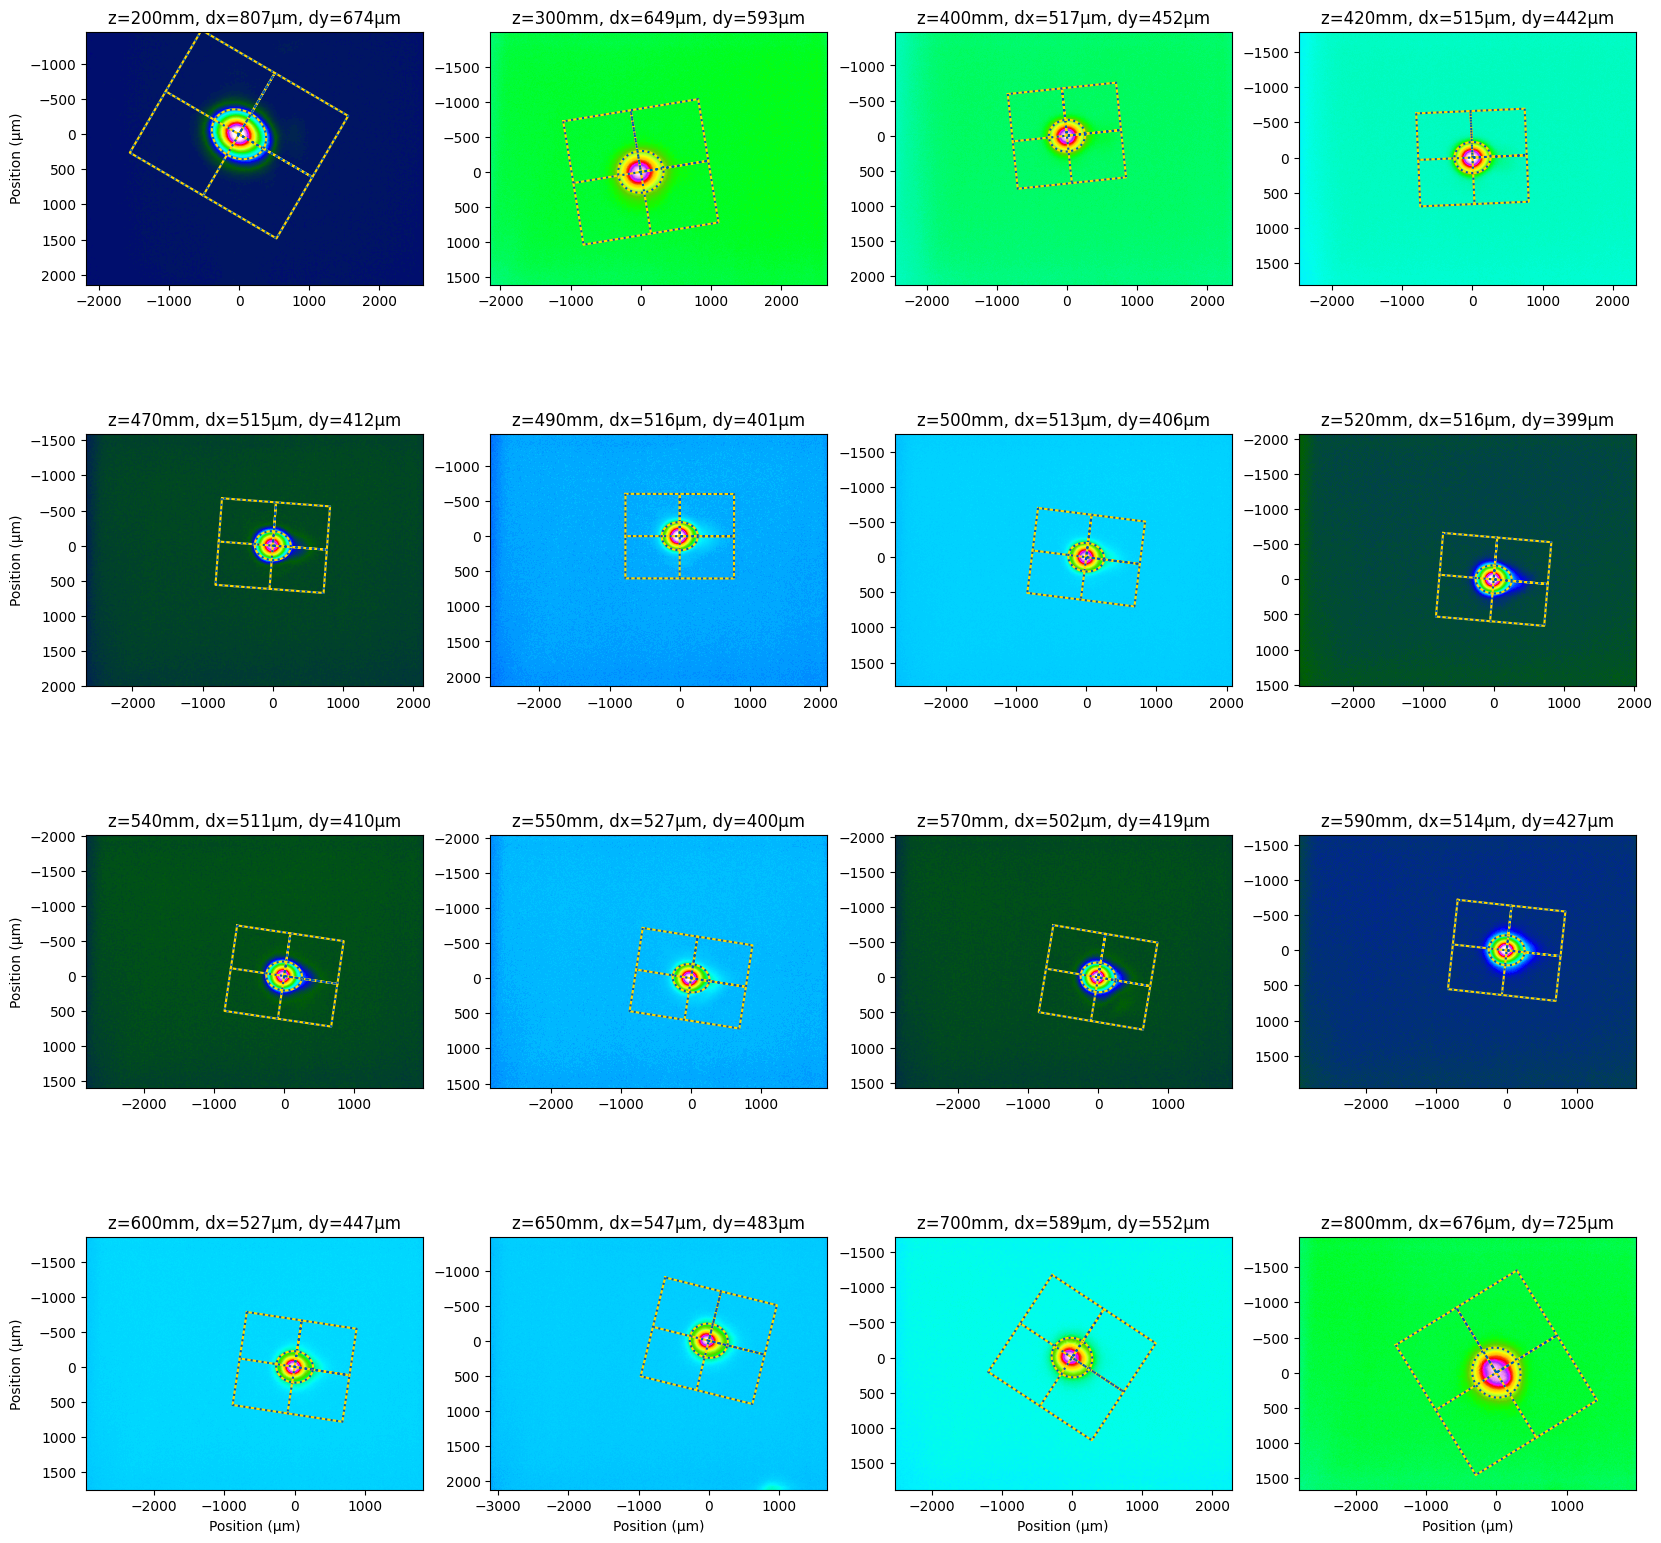

In [4]:
dx, dy = lbs.plot_image_montage(test_img, cols=4, pixel_size=pixel_size_µm, z=z2 * 1e-3, iso_noise=False)

### Image saturation

If one looks closely at the first image (z=200mm), one sees that the image was saturated in the center.  This causes the estimated beam width to be *smaller* than it should be.

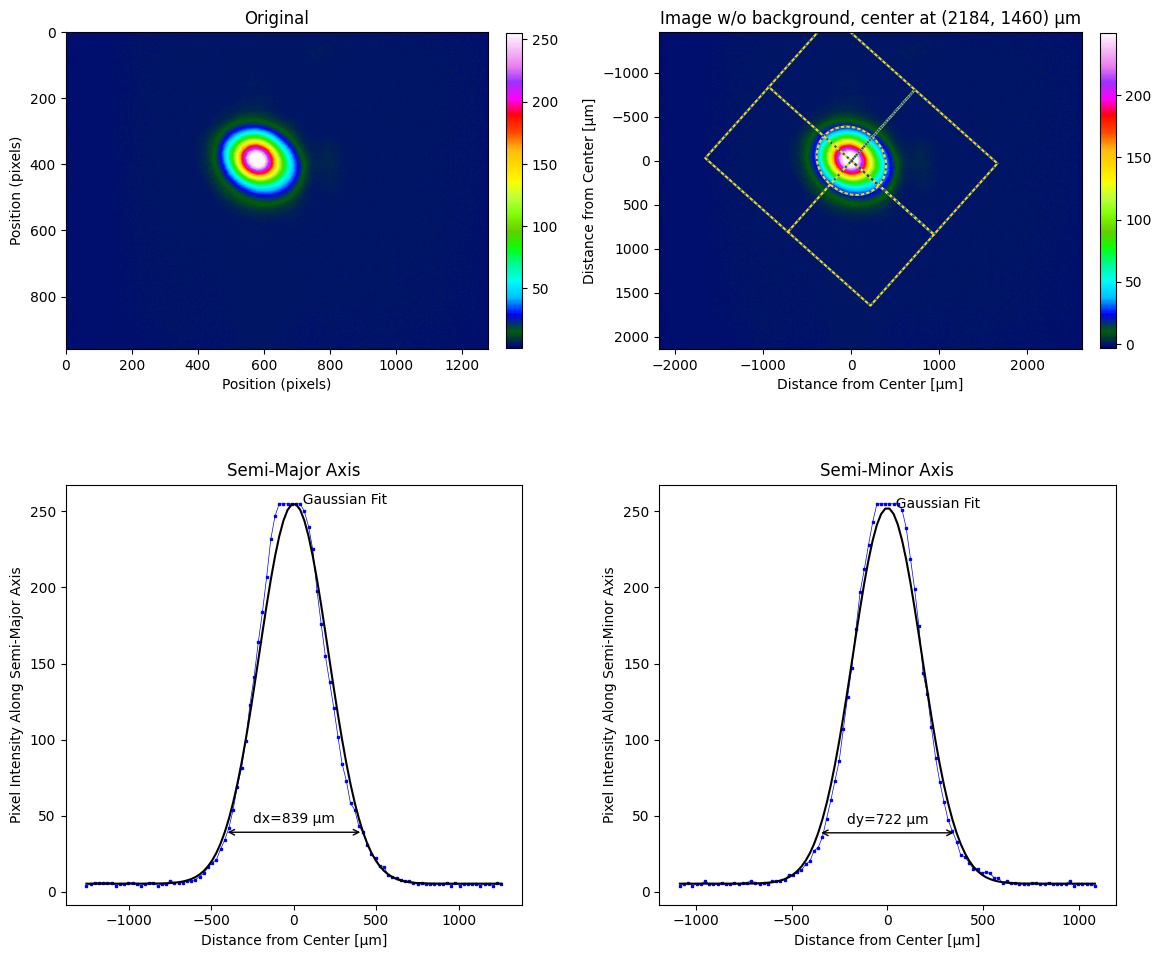

In [5]:
lbs.plot_image_analysis(test_img[0], pixel_size=pixel_size_µm)

### Large background

If one looks closely at the last image (z=800mm), one sees that the background is nearly 100!  The algorithm does a pretty good job of ignoring the background, but again the estimated beam width is *smaller* than it should be.

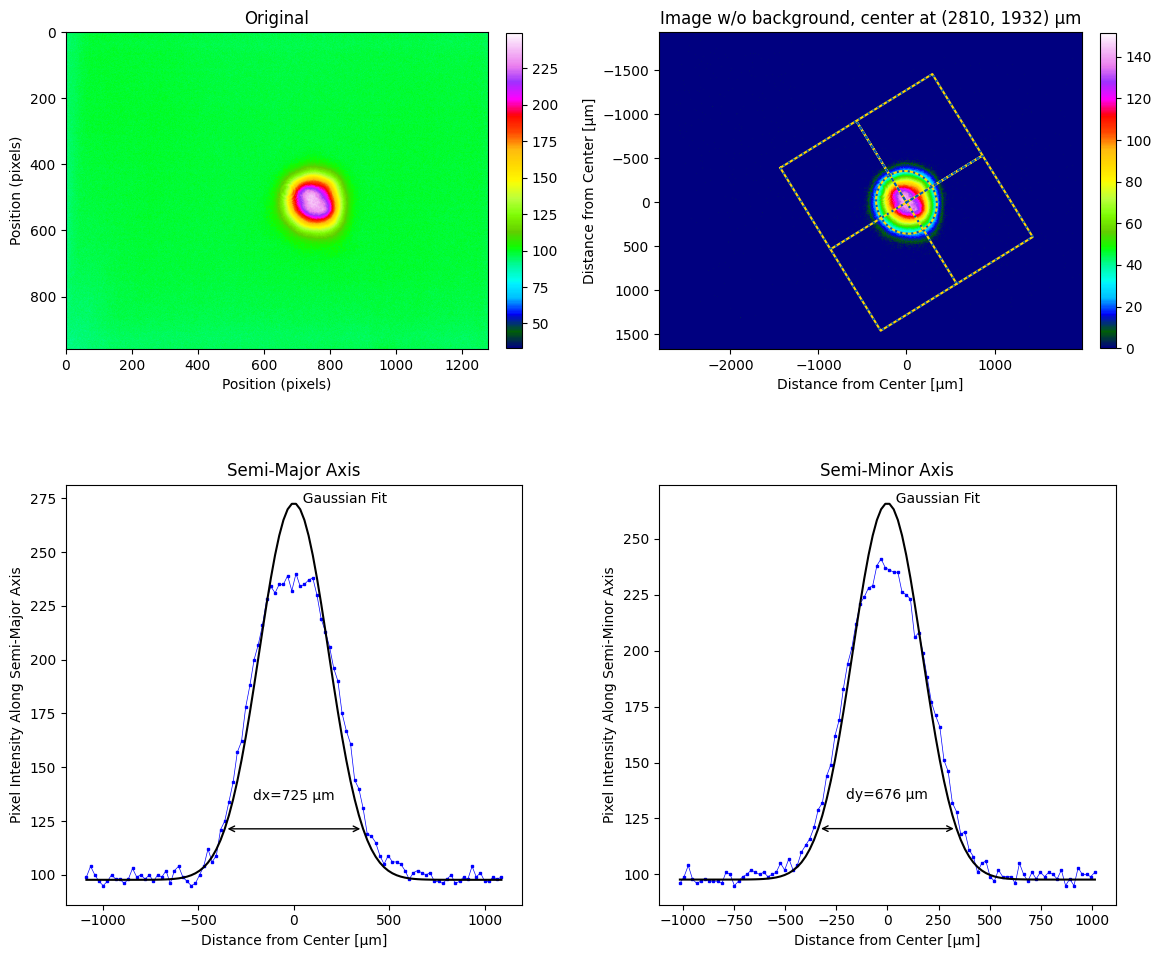

In [6]:
lbs.plot_image_analysis(test_img[15], pixel_size=pixel_size_µm, iso_noise=False)

## TEM$_{00}$, TEM$_{01}$, TEM$_{02}$ Images

This shows what happens with higher order mode laser beams.  There are three images for each beam type taken at different distances along the optical axis.

In [7]:
# read in all the images
z = np.array([[140, 200, 300], [100, 200, 300], [100, 200, 300]])  # mm

tem = np.empty_like(z, dtype=np.ndarray)
for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        filename = repo + "TEM0%d_%dmm.pgm" % (i, z[i, j])
        # 12 bit images but padded with four zero bits
        tem[i, j] = iio.imread(filename) >> 4

Plot the images and their fits.  Notice that the rectangles are cropped in some cases.  

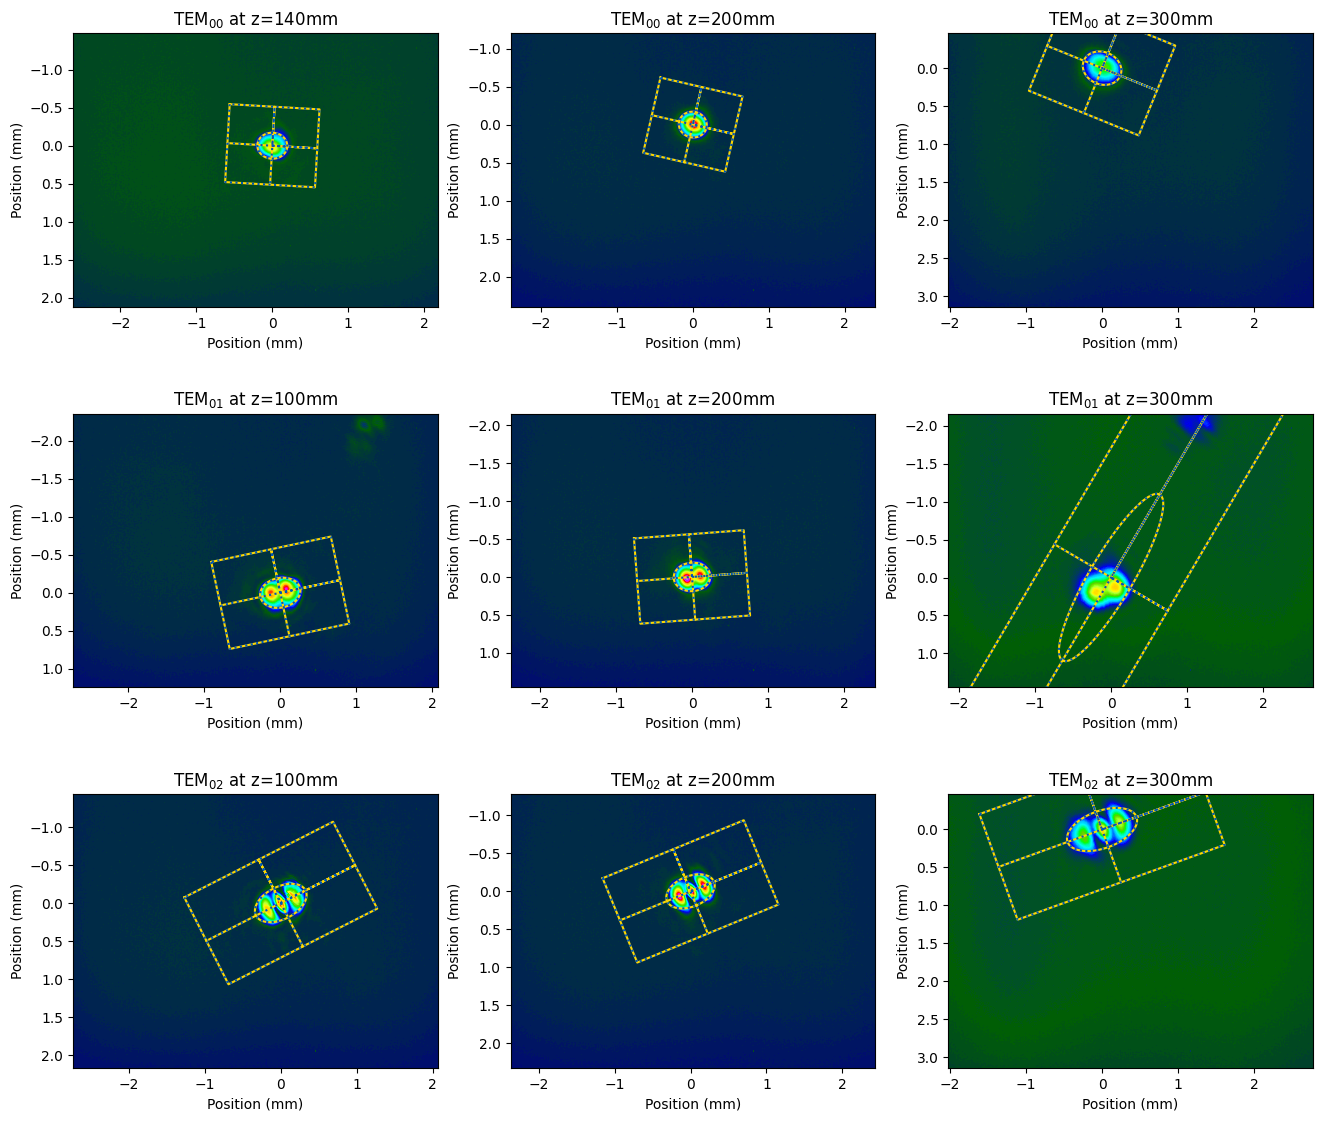

In [8]:
# figure out maximum so all color values match across images
vmax = 0
for i in range(3):
    for j in range(3):
        vmax = max(tem[i, j].max(), vmax)

plt.subplots(3, 3, figsize=(16, 14))
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i * 3 + j + 1)
        lbs.plot_image_and_fit(tem[i, j], pixel_size_µm / 1000, vmax=vmax, units="mm", iso_noise=False)
        plt.title("TEM$_{0%d}$ at z=%dmm" % (i, z[i, j]))

plt.show()

### Fit to TEM$_{02}$ beam

Close examination of the higher order mode at 100mm, shows very plausible results.

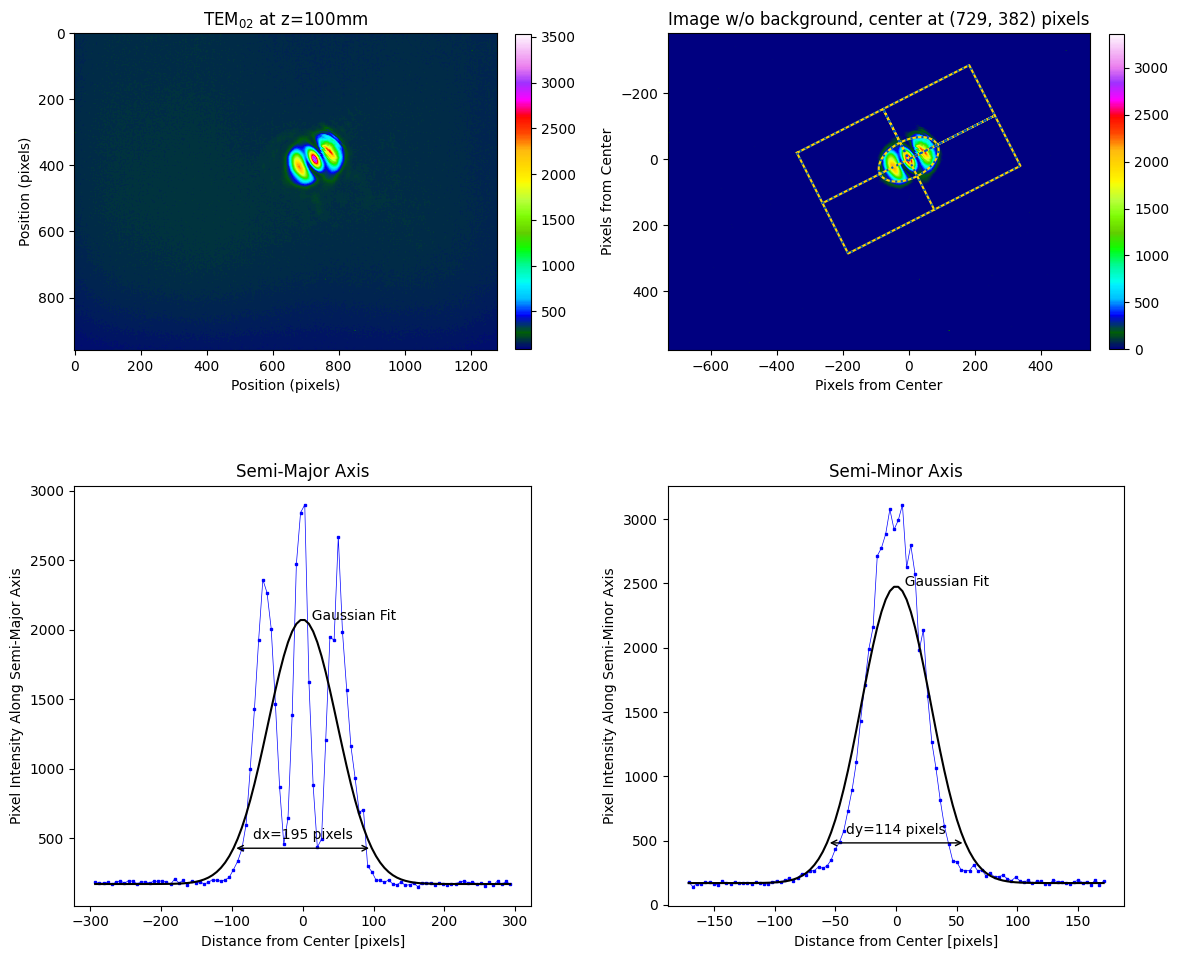

In [9]:
lbs.plot_image_analysis(tem[2, 0], title=r"TEM$_{02}$ at z=100mm", iso_noise=False)

### Cropped integration area

However the TEM$_{02}$ beam at 300mm, has much poorer results.  This is because the beam was not centered in the image and therefore the integration rectangle (3x beam diameter) extended outside the image.  The integration area is cropped and so the integration to find the beam center is unbalanced.

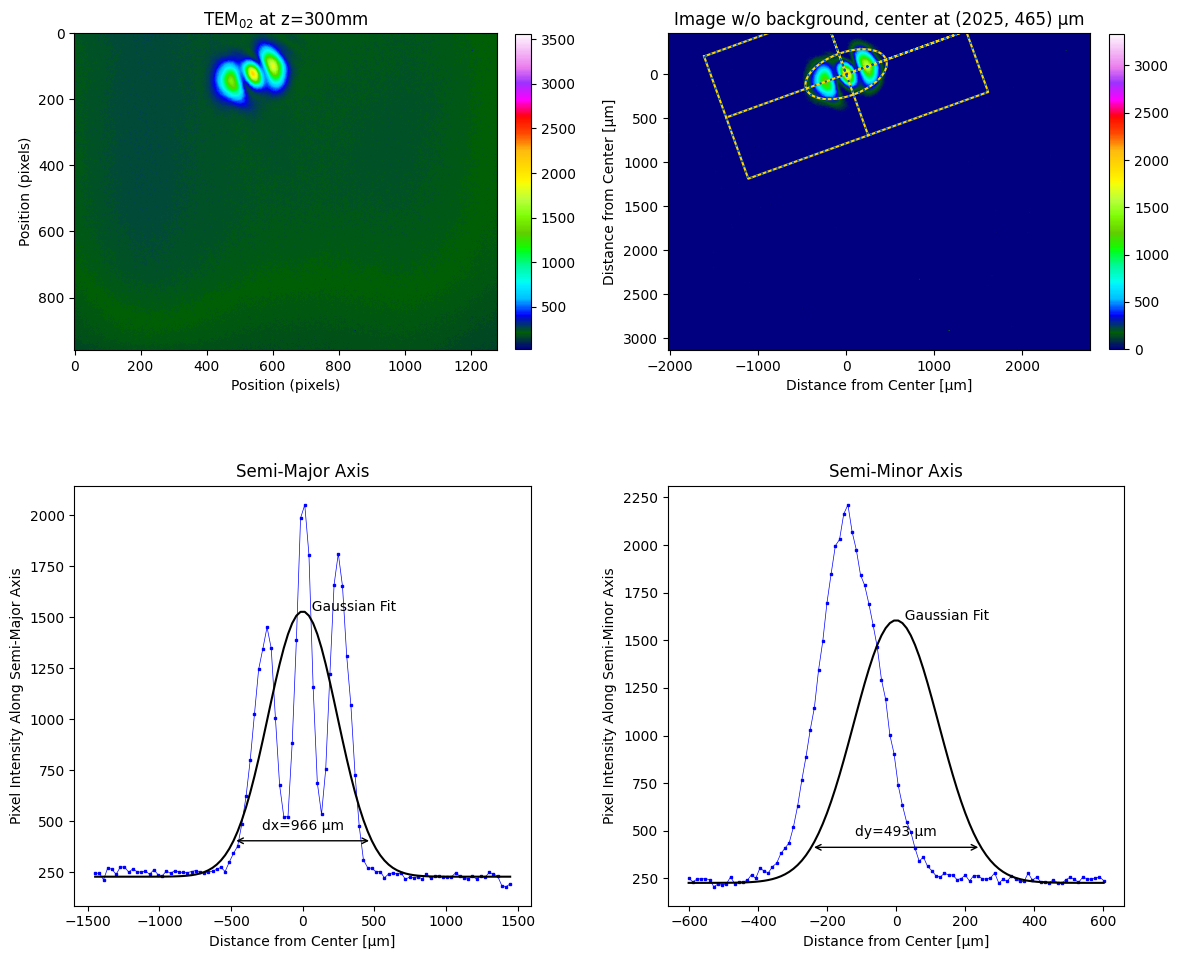

In [10]:
lbs.plot_image_analysis(tem[2, 2], pixel_size=pixel_size_µm, title=r"TEM$_{02}$ at z=300mm", iso_noise=False)